In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from scipy import stats
import xgboost as xgb

from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_curve, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score

In [32]:
data_path = Path.cwd() / "../data"
df_train = pd.read_csv(data_path / "df_train.csv", index_col=0)
df_val = pd.read_csv(data_path / "df_val.csv", index_col=0)

In [33]:
X_train, y_train = df_train.drop(columns='y'), df_train.y
X_test,  y_test = df_val.drop(columns='y'), df_val.y

In [34]:
df_train.min()

customer_age                                  26.000000
customer_sex                                   0.139443
customer_number_of_dependents                  0.000000
customer_education                             0.142649
customer_civil_status                          0.149387
customer_salary_range                          0.127496
customer_relationship_length                  13.000000
customer_available_credit_limit                7.271217
credit_card_classification                     0.143785
total_products                                 1.000000
period_inactive                                0.000000
contacts_in_last_year                          0.000000
credit_card_debt_balance                       0.000000
remaining_credit_limit                         1.098612
transaction_amount_ratio                       0.000000
total_transaction_amount                       6.234411
total_transaction_count                       10.000000
transaction_count_ratio                        0

In [35]:
std = StandardScaler()
num_col = ['customer_age',
 'customer_number_of_dependents',
 'customer_relationship_length',
 'customer_available_credit_limit',
 'total_products',
 'period_inactive',
 'contacts_in_last_year',
 'credit_card_debt_balance',
 'remaining_credit_limit',
 'transaction_amount_ratio',
 'total_transaction_amount',
 'total_transaction_count',
 'transaction_count_ratio',
 'average_utilization']
arr = std.fit_transform(X_train[num_col])
arr = pd.DataFrame(arr, columns = num_col)
X_train = X_train.reset_index(drop=True)
X_train.drop(num_col, axis=1, inplace=True)
X_train = pd.concat([X_train, arr], axis=1)

In [36]:
arr1 = std.transform(X_test[num_col])
arr1 = pd.DataFrame(arr1, columns = num_col)
X_test = X_test.reset_index(drop=True)
X_test.drop(num_col, axis=1, inplace=True)
X_test = pd.concat([X_test, arr1], axis=1)
X_test.head()

,customer_sex,customer_education,customer_civil_status,customer_salary_range,credit_card_classification,customer_available_credit_limit_below_1450,total_products_0_5,total_products_6_10,total_products_more_than_10,period_inactive_0_3,...,total_products,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization
0,0.139443,0.222394,0.163357,0.172105,0.156808,0,1,0,0,1,...,-0.355708,0.652769,-0.410479,0.646830,0.146838,0.613704,-0.060168,0.078117,-0.157251,0.030954
1,0.171719,0.160436,0.149387,0.172105,0.156808,0,1,0,0,1,...,-0.043726,-0.332567,0.495202,0.434758,-1.238419,-0.158690,0.107013,0.630483,-0.062412,1.497251
2,0.171719,0.150126,0.149387,0.172105,0.156808,0,1,0,0,1,...,-0.043726,0.652769,-1.316160,0.173652,-1.036289,0.781424,0.394068,0.503014,-0.168316,1.150541
3,0.139443,0.150126,0.149387,0.127496,0.156808,0,0,1,0,1,...,0.580238,0.652769,-0.410479,0.987616,0.306280,0.401847,0.126248,0.205586,0.038750,-0.008773
4,0.171719,0.150126,0.149387,0.172105,0.156808,0,1,0,0,1,...,-0.667690,-0.332567,-1.316160,1.121233,-0.628446,0.790251,1.799493,2.160110,0.234751,1.089144


In [37]:
y_train = y_train.reset_index(drop=True)
df_train = pd.concat([X_train, y_train], axis=1)

In [38]:
classifiers = [("LogisticRegression",LogisticRegression()),
       ("KNN Classifier", KNeighborsClassifier()),
       ("RandomForest",RandomForestClassifier()),
       ("CatBoost",CatBoostClassifier()),
       ("XGBoost",XGBClassifier())]
for name, model in classifiers:
    if name == "CatBoost":
        model.fit(X_train, y_train, verbose_eval=False)
    else:
        model.fit(X_train, y_train)
    y2 = model.predict(X_test)
    acc_te = accuracy_score(y_test, y2)
    auc = roc_auc_score(y_test, y2)
    print(f"For {name}::\nThe Testing Accuracy is: {acc_te}\nThe Testing AUC is: {acc_te}")
    print("--"*40)

For LogisticRegression::
The Testing Accuracy is: 0.8930899608865711
The Testing AUC is: 0.8930899608865711
--------------------------------------------------------------------------------
For KNN Classifier::
The Testing Accuracy is: 0.9113428943937418
The Testing AUC is: 0.9113428943937418
--------------------------------------------------------------------------------
For RandomForest::
The Testing Accuracy is: 0.9498044328552803
The Testing AUC is: 0.9498044328552803
--------------------------------------------------------------------------------
For CatBoost::
The Testing Accuracy is: 0.9726205997392438
The Testing AUC is: 0.9726205997392438
--------------------------------------------------------------------------------
For XGBoost::
The Testing Accuracy is: 0.9687092568448501
The Testing AUC is: 0.9687092568448501
--------------------------------------------------------------------------------


In [39]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(predictions = True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.97,0.93,0.93,0.97,0.87
LGBMClassifier,0.97,0.92,0.92,0.97,0.25
DecisionTreeClassifier,0.94,0.90,0.90,0.94,0.08
BaggingClassifier,0.95,0.88,0.88,0.95,0.30
AdaBoostClassifier,0.95,0.88,0.88,0.95,0.46
RandomForestClassifier,0.95,0.88,0.88,0.95,0.97
ExtraTreesClassifier,0.93,0.81,0.81,0.92,0.55
SVC,0.92,0.80,0.80,0.91,1.69
LabelPropagation,0.89,0.79,0.79,0.89,1.34


In [40]:
def forward_selection_cv(X, y, model, score_func=roc_auc_score, n_folds=5, max_iter=10):

    selected_features = []
    num_features = X.shape[1]
    best_score = -float('inf')
    iter_since_improvement = 0

    print(f"Performing forward selection with {num_features} features and {n_folds} folds of cross-validation...")

    # Step 1: Iterate over the number of features to select
    for k in range(1, num_features + 1):
        print(f"\nSelecting {k} feature(s)...")
        current_best_score = -float('inf')
        current_best_feature = None

        # Step 2: Iterate over all features not already selected
        for col in X.columns.difference(selected_features):
            features = selected_features + [col]
            X_subset = X[features]

            # Step 3: Compute the cross-validation score using the selected features
            if n_folds == 1:
                # Skip cross-validation if n_folds=1
                model.fit(X_subset, y)
                y_pred = model.predict_proba(X_subset)[:, 1]
                cv_score = score_func(y, y_pred)
            else:
                # Perform cross-validation if n_folds>1
                kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
                scores = []
                for train_index, val_index in kf.split(X_subset):
                    X_train, y_train = X_subset.iloc[train_index], y.iloc[train_index]
                    X_val, y_val = X_subset.iloc[val_index], y.iloc[val_index]

                    model.fit(X_train, y_train)
                    y_pred = model.predict_proba(X_val)[:, 1]
                    score = score_func(y_val, y_pred)
                    scores.append(score)

                # Compute the mean cross-validation score
                cv_score = sum(scores) / len(scores)

            # Step 4: Print the current variable list and cross-validation score
            print(f"Variable list: {features}")
            print(f"CV score: {cv_score}")

            # Step 5: Keep track of the best set of features
            if cv_score > current_best_score:
                current_best_score = cv_score
                current_best_feature = col

        # Step 6: Add the best feature to the selected features
        selected_features.append(current_best_feature)
        print(f"Selected feature(s): {selected_features}")

        # Stopping criterion: no further improvement in cross-validation score
        if current_best_score > best_score:
            best_score = current_best_score
            iter_since_improvement = 0
        else:
            iter_since_improvement += 1
            if iter_since_improvement >= max_iter:
                print(f"No further improvement after {iter_since_improvement} iterations. Stopping forward selection.")
                break

    return selected_features

In [41]:
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

# Initialize an instance of XGBClassifier with the aucpr metric and the scale_pos_weight parameter
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight, n_jobs=-1)

# Perform forward selection with XGBoost
selected_features = forward_selection_cv(X_train, y_train, xgb_model, score_func=roc_auc_score, n_folds=3, max_iter=5)

print("\nSelected features:", selected_features)

Performing forward selection with 40 features and 3 folds of cross-validation...

Selecting 1 feature(s)...
Variable list: ['customer_sex']
CV score: 0.5301257317939423
Variable list: ['customer_education']
CV score: 0.5088481093894709
Variable list: ['customer_civil_status']
CV score: 0.5030695774101769
Variable list: ['customer_salary_range']
CV score: 0.5085300434889565
Variable list: ['credit_card_classification']
CV score: 0.48763490298413986
Variable list: ['customer_available_credit_limit_below_1450']
CV score: 0.5191491279973536
Variable list: ['total_products_0_5']
CV score: 0.532029515414028
Variable list: ['total_products_6_10']
CV score: 0.5325749520074109
Variable list: ['total_products_more_than_10']
CV score: 0.49584956203542824
Variable list: ['period_inactive_0_3']
CV score: 0.5243042644085122
Variable list: ['credit_card_debt_balance_0']
CV score: 0.67677691878442
Variable list: ['transaction_amount_ratio_0_05']
CV score: 0.5669172543039073
Variable list: ['transactio

In [42]:
def random_search(X, y, params, model, n_iter=10, n_splits=5, scoring='roc_auc', seed=42):
    """
    Perform random search with cross-validation.

    Returns:
    results (dict): A dictionary of the results
    """

    # Perform random search with cross-validation
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=n_iter,
        scoring=scoring,
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=n_splits),
        random_state=seed,
        verbose=4
    )
    random_search.fit(X, y)

    # Extract and return the results
    results = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'cv_results': random_search.cv_results_
    }
    return results

In [43]:
X_train_final = X_train[selected_features]
X_test_final = X_test[selected_features]

In [44]:
# Calculate the scale_pos_weight parameter
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()

# Initialize an instance of XGBClassifier with the aucpr metric and the scale_pos_weight parameter
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight)

# Define the hyperparameters to search over
params = {"n_estimators": [50,100,150,200,250,300,350,400],
             "max_depth": np.arange(2,10),
             "learning_rate": np.arange(0.01,0.1,0.02),
             'subsample': np.arange(0.5, 1.0, 0.1),
             'colsample_bytree': np.arange(0.4, 1.0, 0.1),
             'colsample_bylevel': np.arange(0.4, 1.0, 0.1)}

# Perform random search with cross-validation
results = random_search(X_train_final, y_train, params, xgb_model, n_iter=60, n_splits=5, scoring='roc_auc', seed=42)

# Extract the best hyperparameters and the best score
best_params = results['best_params']
best_score = results['best_score']

# Train the model with the best hyperparameters
model = xgb.XGBClassifier(**best_params, random_state=42, objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight)
model.fit(X_train_final, y_train)

# Evaluate the model on the test set
y_pred = model.predict_proba(X_test_final)[:, 1]
auc = roc_auc_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Test AUC: {auc}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'subsample': 0.7, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.08999999999999998, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7999999999999999}
Best score: 0.990157829281392
Test AUC: 0.9898421308497302


In [45]:
model = xgb.XGBClassifier(subsample = 0.7, n_estimators = 150,
                        max_depth = 8, learning_rate = 0.09,
                        colsample_bytree = 0.7, colsample_bylevel = 0.8,
                        objective='binary:logistic', eval_metric='auc', scale_pos_weight=scale_pos_weight)
model.fit(X_train_final, y_train)

y_pr_train = model.predict(X_train_final)
acc_train = accuracy_score(y_train,y_pr_train)
class_re = classification_report(y_train,y_pr_train)
con_mat = confusion_matrix(y_train,y_pr_train)
auc_train = roc_auc_score(y_train, y_pr_train)
print("Confusion Matrix:\n",con_mat)
print("\n")
print("The accuracy of the model:",(acc_train)*100)
print("\n")
print("The classification report:\n",class_re)
print(auc_train)

Confusion Matrix:
 [[5162   12]
 [   0  962]]


The accuracy of the model: 99.80443285528031


The classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5174
           1       0.99      1.00      0.99       962

    accuracy                           1.00      6136
   macro avg       0.99      1.00      1.00      6136
weighted avg       1.00      1.00      1.00      6136

0.9988403556242752


In [46]:
y_pr_test = model.predict(X_test_final)
acc_test = accuracy_score(y_test, y_pr_test)
class_re1 = classification_report(y_test,y_pr_test)
con_mat1 = confusion_matrix(y_test,y_pr_test)
auc_test = roc_auc_score(y_test, y_pr_test)
print("Confusion Matrix:\n",con_mat1)
print("\n")
print("The accuracy of the model:",(acc_test)*100)
print("\n")
print("The classification report:\n",class_re1)
print(auc_test)

Confusion Matrix:
 [[1256   36]
 [  20  222]]


The accuracy of the model: 96.34941329856585


The classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1292
           1       0.86      0.92      0.89       242

    accuracy                           0.96      1534
   macro avg       0.92      0.94      0.93      1534
weighted avg       0.96      0.96      0.96      1534

0.9447457974055216


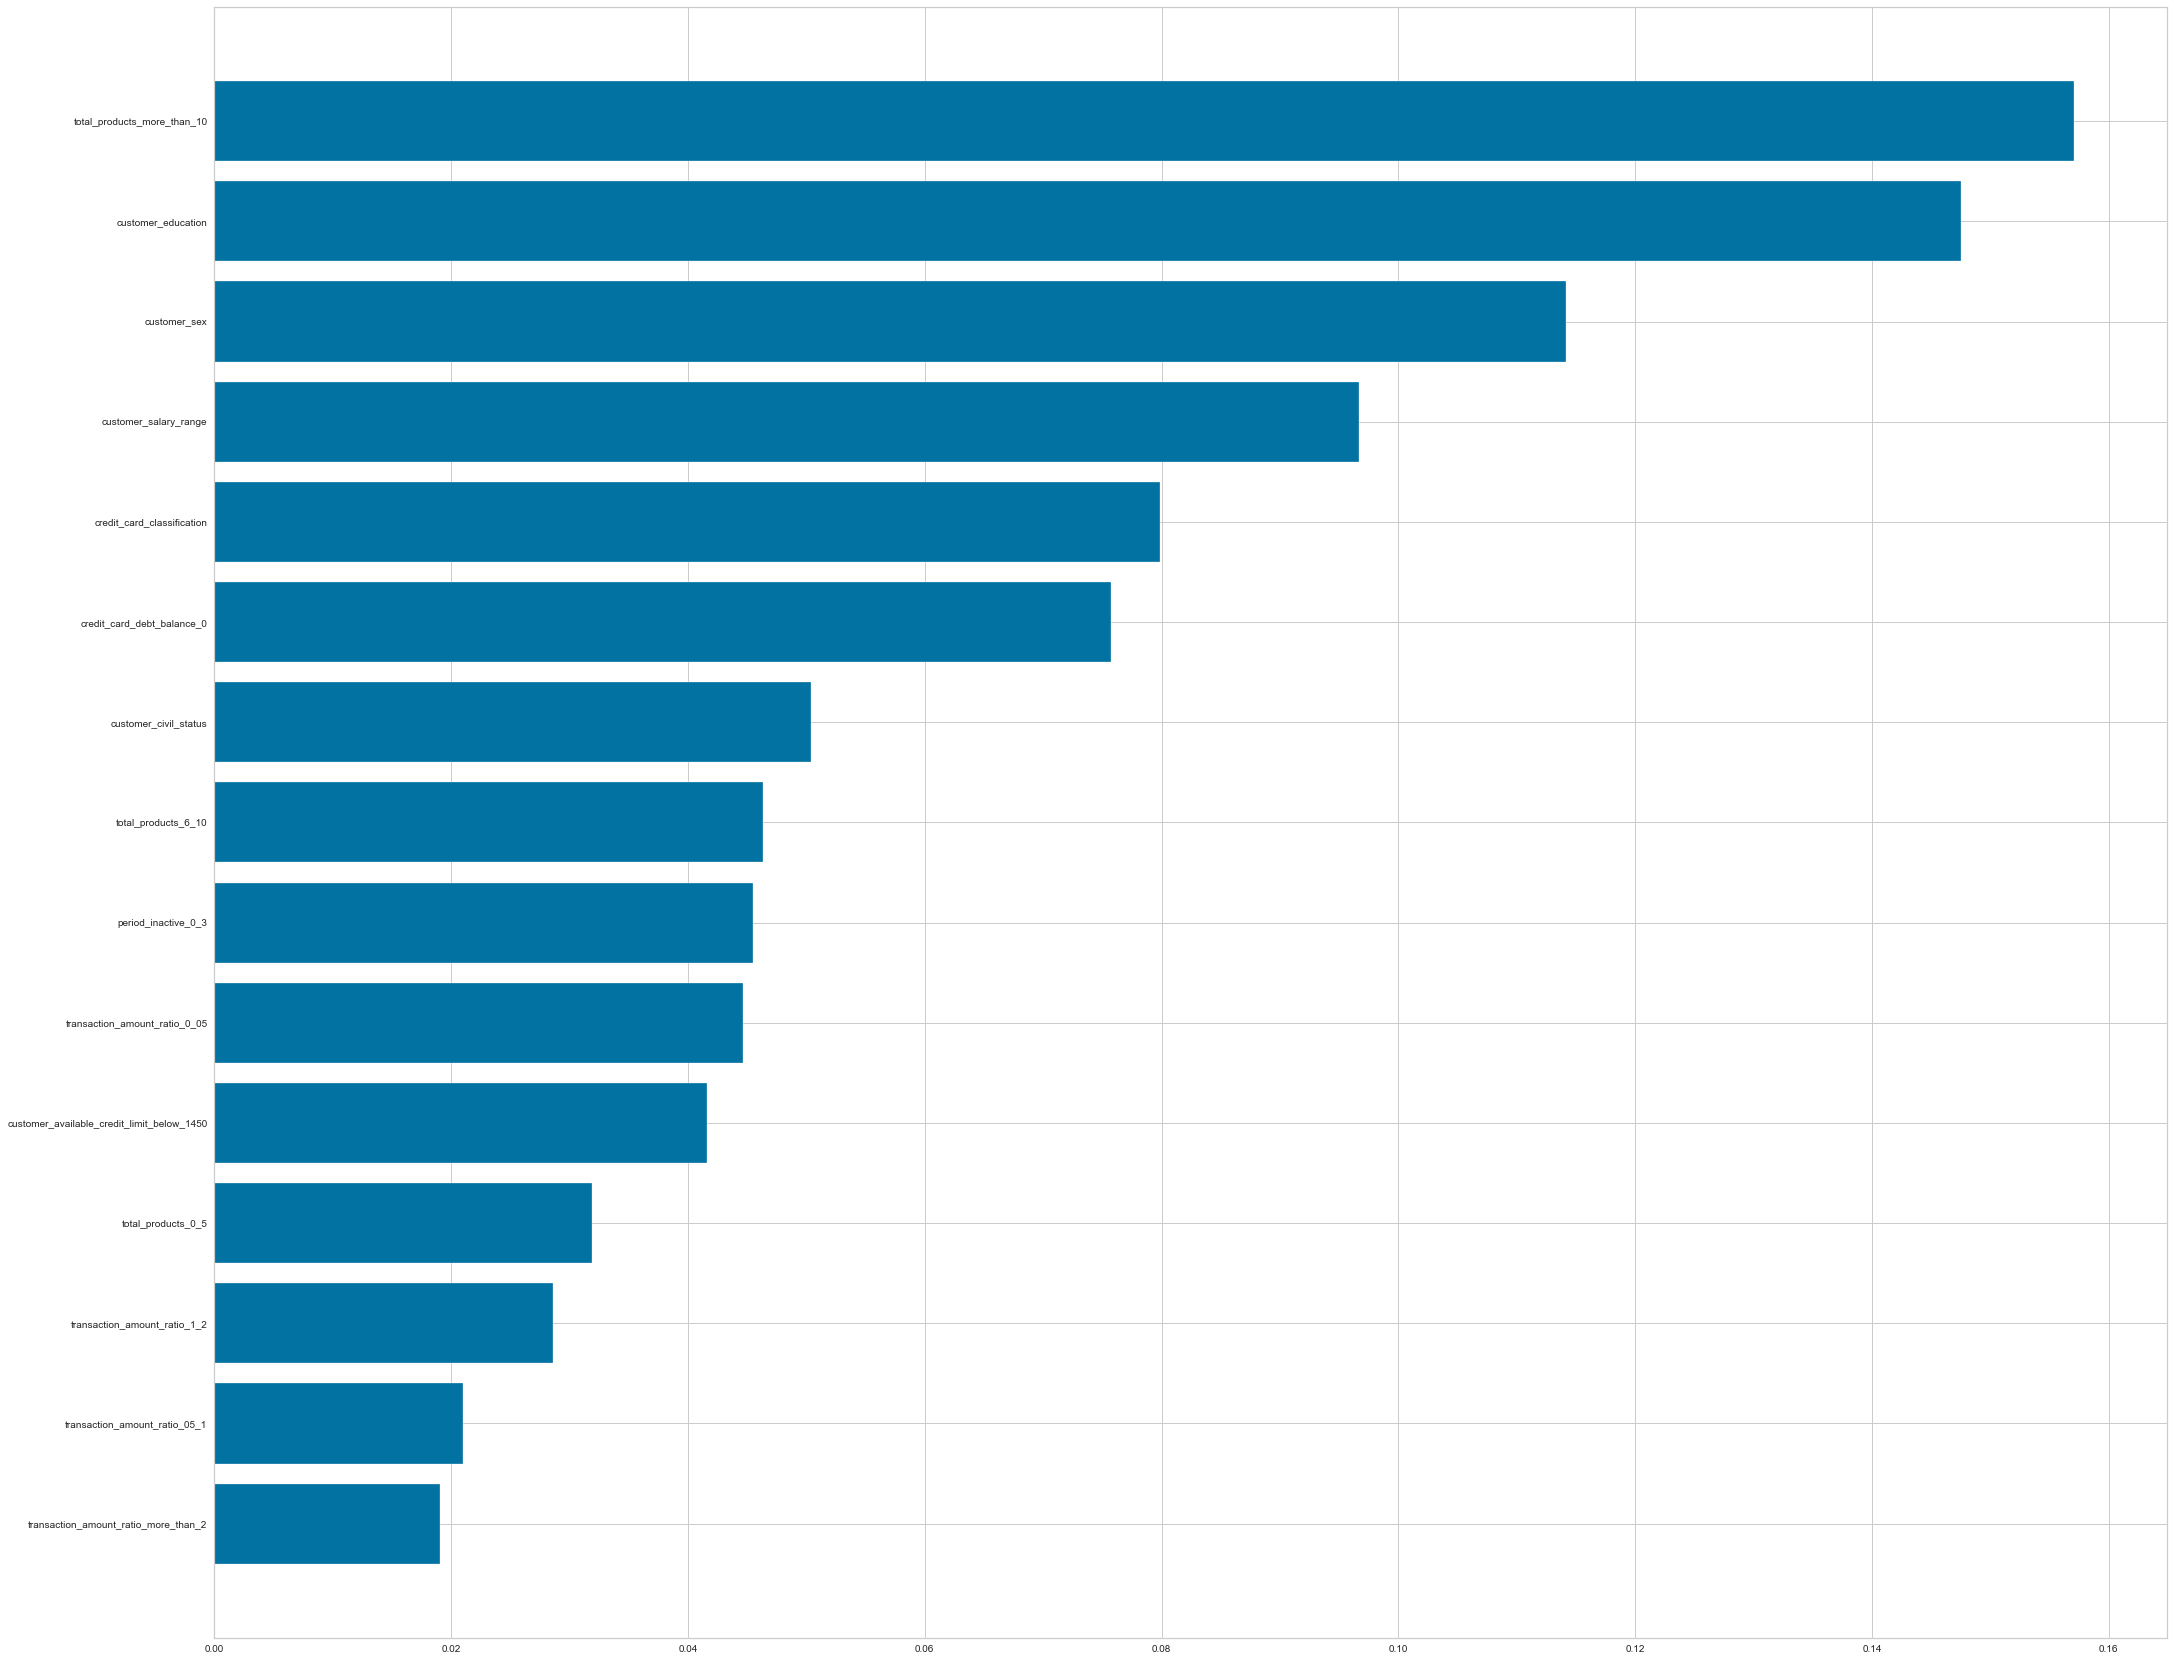

In [47]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(35, 30))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

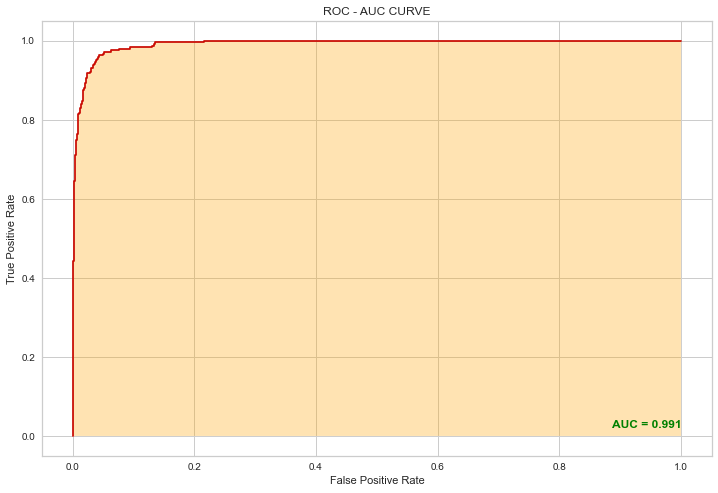

In [48]:
# Ploting the Roc - Auc Curve on Testing data
y_prob = model.predict_proba(X_test_final)
y_pr   = y_prob[:,1]
auc_score = roc_auc_score(y_test, y_pr)
fpr,tpr,threshold = roc_curve(y_test,y_pr)
plt.figure(figsize=(12, 8))
plt.plot(fpr,tpr, "r")
plt.text(1, 0.02, 'AUC = %0.3f' % auc_score, ha='right', fontsize=12,weight='bold', color='green')
plt.fill_between(fpr, tpr, facecolor='orange', alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC CURVE")
plt.show()

Text(88.0, 0.5, 'Truth')

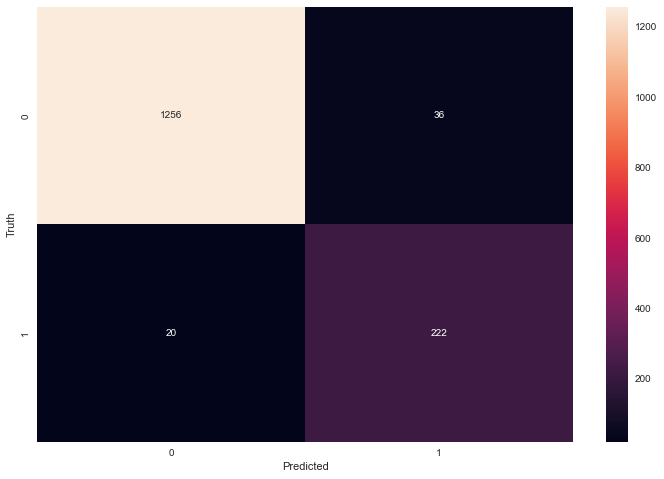

In [49]:
cm = confusion_matrix(y_test, model.predict(X_test_final))
plt.figure(figsize = (12,8))
ax = sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

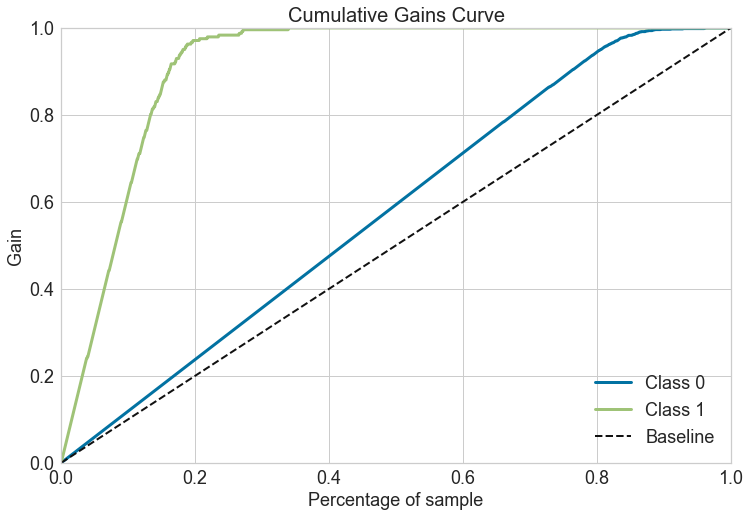

In [50]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, y_prob, figsize=(12, 8), title_fontsize=20, text_fontsize=18)
plt.show()

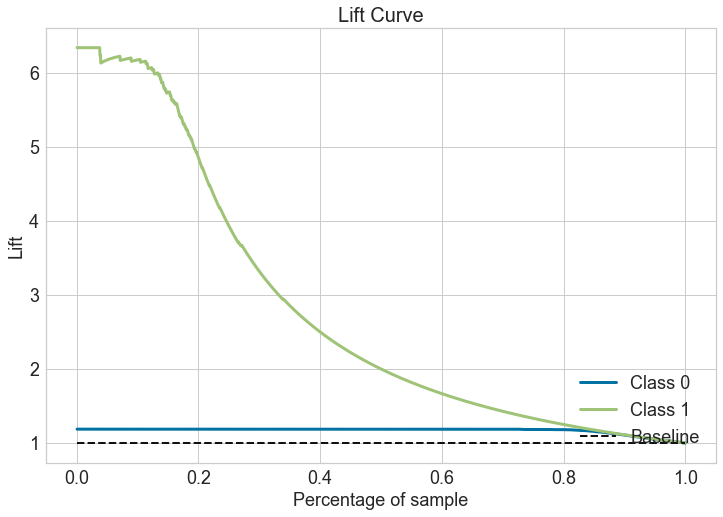

In [51]:
skplt.metrics.plot_lift_curve(y_test, y_prob, figsize=(12, 8), title_fontsize=20, text_fontsize=18)
plt.show()